In [214]:
import requests
from bs4 import BeautifulSoup
import bs4
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mk/nltk_data...


In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


# Let's Scrape Movie Plots from Wikipedia for analysis

### Here are the names and wikipedia links to the movies we will scrape

In [3]:
movie_name = ['Get Out','A Quiet Place','Train to Busan','Paranormal Activity','Saw','Texas Chainsaw', 'Cabin in the Woods',
             'American Psycho','The Conjuring','Annabelle','Insidious','Us','Gerald\'s Game','Scream','Truth or Dare']

urls = ['https://en.wikipedia.org/wiki/Get_Out','https://en.wikipedia.org/wiki/A_Quiet_Place_(film)',
       'https://en.wikipedia.org/wiki/Train_to_Busan','https://en.wikipedia.org/wiki/Paranormal_Activity',
       'https://en.wikipedia.org/wiki/Saw_(2004_film)','https://en.wikipedia.org/wiki/The_Texas_Chainsaw_Massacre_(2003_film)',
       'https://en.wikipedia.org/wiki/The_Cabin_in_the_Woods','https://en.wikipedia.org/wiki/American_Psycho_(film)',
       'https://en.wikipedia.org/wiki/The_Conjuring','https://en.wikipedia.org/wiki/Annabelle_(film)',
       'https://en.wikipedia.org/wiki/Insidious_(film)', 'https://en.wikipedia.org/wiki/Us_(2019_film)',
       'https://en.wikipedia.org/wiki/Gerald%27s_Game_(film)', 'https://en.wikipedia.org/wiki/Scream_(1996_film)',
       'https://en.wikipedia.org/wiki/Truth_or_Dare_(2018_film)']

## Define a Class to extract the Title and Plot

In [4]:
class Movie():
    def __init__(self,url):
        self.url = url
        self.response = requests.get(self.url, headers=headers)
        self.soup = BeautifulSoup(self.response.text, 'lxml')
        
    def Name(self):
        title= self.soup.title.get_text().split('-')[0]
        return title
    
    def Plot(self):
        parser = self.soup.find('div',class_='mw-parser-output')
        stopword = 'Cast[edit]'  
        combined_plot=[]
        for i in parser.find_all('h2'):
            if i.get_text() == 'Plot[edit]': 
                for x in i.next_siblings:
                    if isinstance(x,bs4.element.Tag):
                        plots = x.get_text()
                        combined_plot.append(plots)
                        combined_plot = ["".join(x for x in combined_plot)]
                        if x.get_text() == stopword:
                            break
        return combined_plot

# Store the results in a dictionary for now
instances = {}
for name, url in zip(movie_name, urls):
    instances[name] = Movie(url)


## HOW OUR DATA LOOKS
print('FOR EXAMPLE: ')
print()
print('Name of the Movie: {}'.format(instances['Get Out'].Name()))
print()
print(f"Plot of the Movie: {instances['Get Out'].Plot()}")

FOR EXAMPLE: 

Name of the Movie: Get Out 

Plot of the Movie: ['Black photographer Chris Washington is apprehensive as he prepares to meet the family of his white girlfriend, Rose Armitage. Later, at the Armitage house in rural Upstate New York, Rose\'s brother Jeremy and their parents, neurosurgeon Dean and hypnotherapist Missy, make disconcerting comments about black people. Chris witnesses strange behavior from the estate\'s black housekeeper Georgina and groundskeeper Walter.\nWhen Chris is unable to sleep, Missy pressures him into a hypnotherapy session to cure his smoking addiction. In a trance, he expresses guilt over his mother\'s death in a hit-and-run when he was a child, and sinks into a void Missy calls the "Sunken Place". The next morning, he assumes that the encounter was a dream, but cigarettes now repulse him. Georgina unplugs his phone "accidentally," draining its battery.\nDozens of wealthy white people arrive for the Armitages\' annual get-together. They express adm

In [5]:
## this is the raw Corpus
pd.set_option('max_colwidth',130)
movie_df = pd.DataFrame()

for a in instances.keys():
    movie_df= movie_df.append({'Name':instances[a].Name(), 'Plot':instances[a].Plot()},ignore_index=True)

movie_df


,Name,Plot
0,Get Out,"[Black photographer Chris Washington is apprehensive as he prepares to meet the family of his white girlfriend, Rose Armitage...."
1,A Quiet Place (film),"[Throughout the year of 2020, most of Earth's human and animal populations have been annihilated by sightless extraterrestrial..."
2,Train to Busan,"[Fund manager Seok-woo is a cynical workaholic and divorced father of his daughter Su-an, who wants to spend her birthday with..."
3,Paranormal Activity,"[In 2006, Katie and Micah, a young couple, move to a new house in San Diego. Katie claims an evil presence has been haunting h..."
4,Saw (2004 film),"[Photographer Adam awakens in a dilapitated bathtub, with his ankle chained to a pipe. Across the room is oncologist Dr Lawren..."
5,The Texas Chainsaw Massacre (2003 film),"[On August 18, 1973, five young adults – Erin, her boyfriend Kemper, and their friends Morgan, Andy, and Pepper – are on their..."
6,The Cabin in the Woods,"[In an underground laboratory, engineers Sitterson and Hadley discuss plans for a mysterious ritual, after a similar operation..."
7,American Psycho (film),"[In 1987, wealthy New York investment banker Patrick Bateman’s life revolves around dining at trendy restaurants while keeping..."
8,The Conjuring,"[In 1971, Roger and Carolyn Perron move into a farmhouse in Harrisville, Rhode Island, with their five daughters Andrea, Nancy..."
9,Annabelle (film),"[In Santa Monica, California, John Form, a doctor, presents his expectant wife Mia with a rare vintage porcelain doll as a gif..."


## Data Cleaning (lowercase, punctuation, digits, minimum 3 letters, stopwords, lemmatization)

In [50]:
def preprocessing(doc):
    global sw
    sw = stopwords.words('english') ## establish stopwords
    newStopWords = ['jeremy','missy','chris','walter','logan','georgina', 'regan','marcus','evelyn','yonsuk','seongkyeong',
               'sanghwa','yongguk', 'seokwoo', 'katie','john','adam','lawrence','alison','morgan','andy','erin',
               'curt', 'bateman', 'allen','christie', 'lorraine', 'carolyn', 'christine', 'cindy', 'josh','dalton',
               'jason','gabe', 'tyler', 'wilson','jessie','sidney', 'billy','casey','randy','gale','olivia','lucas',
               'carter','markie'] ## insert these names of characters as stopwords
    sw.extend(newStopWords)
    
    newstr = str(doc).lower() ## lower case the document

    newstr = re.sub(r'[%s%s]'%(string.punctuation,string.digits),'',newstr) ## get rid of punctuation and digits

    newstr = re.sub(r'\b\w{,3}\b','',newstr) #take out words containing fewer than 3 letters

    newstr= newstr.replace('\\n',' ').replace('\\',' ').replace('–',' ') ##replace of \\n, \\, - symbols

    newstr = newstr.split()
    newstr = ' '.join([i for i in newstr if i not in sw]) ## get rid of stopwords
    newstr = ' '.join([(WordNetLemmatizer()).lemmatize(w) for w in newstr.split()]) ## lemmatize words
    return newstr


movie_df['Plot'] = movie_df['Plot'].apply(preprocessing)

## Binary Term Frequency

In [44]:
corpus = [plot for plot in movie_df['Plot']]

binary_term= TfidfVectorizer(
    binary=True, norm=False, # tf - binary
    use_idf=False, smooth_idf=False, # idf - none
    lowercase=True, stop_words='english', 
    min_df=1, max_df=0.99, max_features=None, 
    ngram_range=(1, 1))

btf = pd.DataFrame(binary_term.fit_transform(corpus).toarray(),columns = binary_term.get_feature_names(),
                  index = movie_name)

text = btf.sum().sort_values(ascending=False).nlargest(20).index
text


Index(['kill', 'attack', 'house', 'reveals', 'escape', 'death', 'night',
       'place', 'make', 'tell', 'explains', 'help', 'home', 'shoot', 'police',
       'family', 'drive', 'door', 'inside', 'arrives'],
      dtype='object')

## Bag of Words

In [199]:
from sklearn.feature_extraction.text import TfidfVectorizer
bag_words = TfidfVectorizer(
    binary=False, norm=None, 
    use_idf=False, smooth_idf=False, 
    lowercase=True, stop_words='english', 
    min_df=1, max_df=0.99, max_features=None, 
    ngram_range=(1, 1))

bow_ = bag_words.fit_transform(corpus)

bow = pd.DataFrame(bow_.toarray(), columns = bag_words.get_feature_names(),
                  index =movie_name )

bow.head()


house     52.0
family    27.0
father    26.0
kill      26.0
night     25.0
demon     23.0
escape    23.0
game      22.0
tell      22.0
micah     21.0
dtype: float64

# Exploratory Data Analysis

## Terms that appear most frequently across all of the 15 movie plots (check Binary Term Frequency section for 'text')

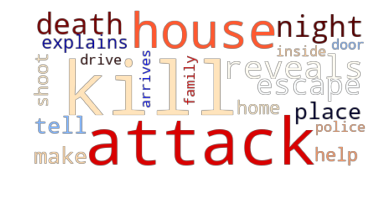

In [47]:
wc = WordCloud(max_words=20,background_color=None,mode = 'RGBA',colormap = 'flag').generate(' '.join(text))

plt.imshow(wc,interpolation='bilinear')
plt.axis("off");

# These are the most frequently re-occuring words in the 15 horror movies we are analyzing. 
# As expected, most plots revolve around the keywords 'kill,attack, death, police, escape, night' and etc

## 'House' and 'Kill' are two of the most mentioned terms in the corpus. Let's create a scatterplot to see how many times these words are mentioned in each of the movie plots. 

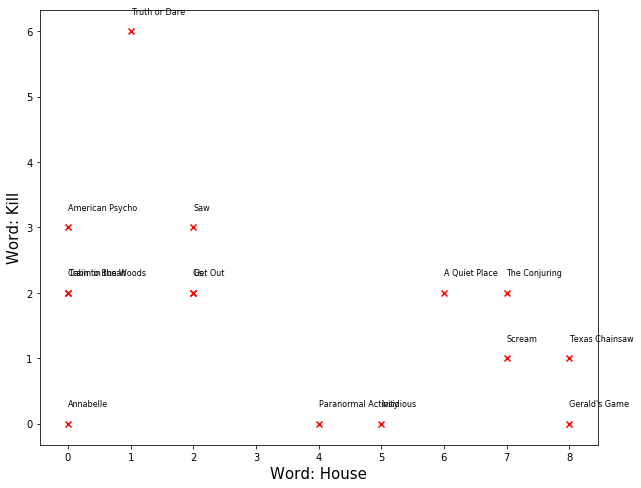

In [210]:
plt.subplots(figsize=(10,8))
for i,type in enumerate(movie_name):
    x = bow['house'][i]
    y = bow['kill'][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.xlabel('Word: House',fontsize= 15)
    plt.ylabel('Word: Kill',fontsize=15)
    plt.text(x, y+0.3, movie_name[i], fontsize=8,verticalalignment='center')
    
#You can see Truth or Dare mentions the word Kill 6 times in its Wikipedia plot while Texas Chainsaw and 
#Gerald's game mentions the words House up to 8 times each in their plots. 

## Making a word cloud for each move plot based on the corpus we created after data cleaning (check out 'movie_df')

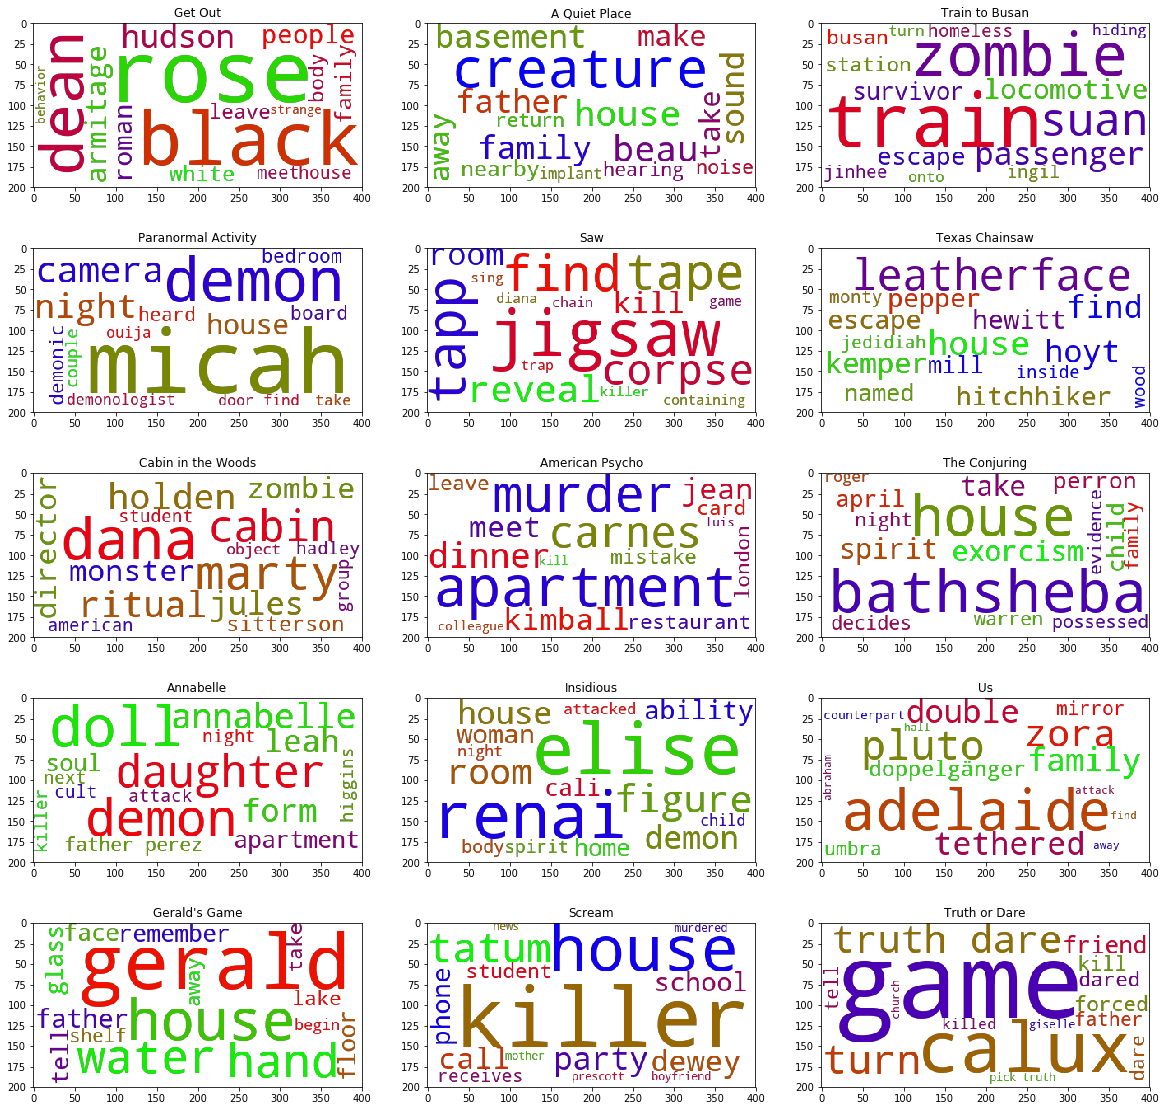

In [52]:
plt.figure(figsize= (20,20))

for i in range(len(movie_df)):
    plt.subplot(5,3,i+1)
    wc1 = WordCloud(max_words=15,background_color=None,mode = 'RGBA',colormap = 'brg',stopwords=sw).generate(movie_df.loc[i]['Plot'])
    plt.imshow(wc1)
    plt.title(movie_name[i])


### I have watched over half of these movies and I can say these wordclouds to a decent job explaining to me what the premise of the movie is. 

# Topic Modeling (LDA)

In [152]:
lda = LatentDirichletAllocation(
    n_components=3,
    doc_topic_prior= 50/3,
    topic_word_prior=0.01,
    learning_method='online', 
    learning_offset=50,
    random_state=1) 

lda_model = lda.fit(bow_)
lda_trans = lda.transform(bow_)


array([[0.38310065, 0.22167768, 0.39522167],
       [0.13263884, 0.1762488 , 0.69111237],
       [0.23106912, 0.62115039, 0.1477805 ],
       [0.78525742, 0.112511  , 0.10223158],
       [0.22414895, 0.26824454, 0.50760651],
       [0.16330778, 0.59082611, 0.2458661 ],
       [0.11703582, 0.15718704, 0.72577715],
       [0.70476971, 0.12098412, 0.17424617],
       [0.54830514, 0.1829368 , 0.26875807],
       [0.65445534, 0.16879715, 0.17674751],
       [0.78754137, 0.11173552, 0.10072311],
       [0.67416757, 0.1543208 , 0.17151163],
       [0.18705804, 0.65868678, 0.15425517],
       [0.13536027, 0.73438516, 0.13025457],
       [0.07619072, 0.84263494, 0.08117434]])

## Topic-Term Matrix

In [136]:
TopicMatrix = pd.DataFrame(np.round(lda_model.components_,4), columns = bag_words.get_feature_names())
TopicMatrix

,abandon,abandoned,abbott,abbotts,abduct,abducted,abduction,abducts,ability,able,...,yell,yelling,york,young,younger,youtube,zombie,zombified,zone,zora
0,0.9587,0.9398,0.6235,0.5688,0.8993,0.5999,0.8721,0.6338,2.3442,1.0731,...,0.8334,0.6043,1.0168,2.1783,0.7477,0.6224,2.1342,0.5606,0.6526,1.9944
1,0.5680,1.4937,0.5546,0.6405,0.6782,0.5562,0.8415,0.5619,0.7454,0.9050,...,0.6418,0.8302,0.6457,1.9354,0.8482,0.6970,3.2150,0.6013,0.7078,1.0521
2,0.6257,1.0081,0.7359,0.8077,0.6153,0.9829,1.1138,0.7322,0.8294,0.9622,...,0.9211,0.7812,0.7136,1.8115,0.8904,0.6458,2.3644,0.8299,0.5877,1.3882


In [138]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
    
print_top_words(lda_model, bag_words.get_feature_names(), 20)

# it isn't the best split of topics but interesting to see nonetheless

Topic #0: house demon micah night elise family adelaide renai daughter room body child escape attack kill apartment woman figure reveals doll

Topic #1: house game father truth kill tell turn dare night killed escape killer away gerald leatherface friend calux shoot make death

Topic #2: house family creature father dana escape kill away attack tell attacked leatherface marty home game jigsaw make cabin night basement



## Doc Term Matrix

In [150]:
DocTopicMatrix = pd.DataFrame(np.round(lda_trans, 4), columns =['Topic0','Topic1','Topic2'],index = movie_name)
DocTopicMatrix['dominant_topic'] = np.argmax(DocTopicMatrix.values, axis=1)

DocTopicMatrix.head()

# this shows which topic is most prevalent(dominant) in each of the movies. 

,Topic0,Topic1,Topic2,dominant_topic
Get Out,0.3831,0.2217,0.3952,2
A Quiet Place,0.1326,0.1762,0.6911,2
Train to Busan,0.2311,0.6212,0.1478,1
Paranormal Activity,0.7853,0.1125,0.1022,0
Saw,0.2241,0.2682,0.5076,2
Texas Chainsaw,0.1633,0.5908,0.2459,1
Cabin in the Woods,0.1170,0.1572,0.7258,2
American Psycho,0.7048,0.1210,0.1742,0
The Conjuring,0.5483,0.1829,0.2688,0
Annabelle,0.6545,0.1688,0.1767,0


## Simple Sentiment Analysis
#### i can't imagine any of these plots to be 'positive' given they're horror movies with words like death, kill, etc

In [223]:
def Sentiment(doc):
    sentiment = SentimentIntensityAnalyzer()
    score = sentiment.polarity_scores(doc)
    return score

plot_sentiment = [Sentiment(plot) for plot in movie_df['Plot']]

sentiment_df = pd.DataFrame(plot_sentiment, columns = ['neg','neu','pos','compound'], index = movie_df['Name'])

sentiment_df

,neg,neu,pos,compound
Name,,,,
Get Out,0.259,0.670,0.072,-0.9959
A Quiet Place (film),0.206,0.680,0.114,-0.9894
Train to Busan,0.251,0.630,0.120,-0.9939
Paranormal Activity,0.184,0.739,0.077,-0.9902
Saw (2004 film),0.341,0.580,0.079,-0.9987
The Texas Chainsaw Massacre (2003 film),0.233,0.704,0.063,-0.9965
The Cabin in the Woods,0.241,0.645,0.114,-0.9945
American Psycho (film),0.304,0.592,0.104,-0.9983
The Conjuring,0.187,0.699,0.115,-0.9896
